# Lecture 4 - More Blocking and Power

## Today's Learning Objectives

1. Propose the use of control, blocking, randomization, and replication in the design of an A/B testing.
2. Contrast the performance of blocking versus non-blocking designs with increasing overall sample sizes.
3. Relate the statistical notion of power to the real-world utility of an experiment in an A/B testing sample size computation.
4. Contrast the performance of blocking versus non-blocking designs in terms of block homogeneity.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 8)
library(tidyverse)
library(broom)
library(cowplot)
library(scales)
library(pwr)
library(reshape2)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘cowplot’




The following object is masked from ‘package:lubridate’:

    stamp





Attaching package: ‘scales’




The following object is masked from ‘package:purrr’:

    discard




The following object is masked from ‘package:readr’:

    col_factor





Attaching package: ‘reshape2’




The following object is masked from ‘package:tidyr’:

    smiths




## Previously...

In {doc}`lecture3_randomization_and_blocking`, we considered blocking in our experimental design versus non-blocking and their associated modelling frameworks. Blocking can be our friend if we consider it from the **first experimental stages** (i.e., **when planning our experiment!**). Note you need to clearly know how your population is **stratified** (more on this matter in {doc}`appendix_blocking_and_stratification`).

Nevertheless, we need to explore other essential matters when trying A/B testing. For instance:

- **How large should our overall sample size be to have an acceptable power?** 
- **Will we be able to capture a given treatment effect of "business importance"?** 
- If we use a blocking design, **what characteristics should our blocks have?**

## 1. Blocking Simulation Setup

Let us retake our simulation from {doc}`lecture3_randomization_and_blocking` to elaborate on the concepts we will see today.

### 1.1. Main Statisical Inquiry

You aim to run an A/B testing on a **subscription website** to experiment with a new layout (i.e., the **experimental treatment**) to increase the mean duration time (hours) on your website (i.e., the **response**). You will compare this new layout versus the existing one (i.e., the **control treatment**). Therefore, you will have an **experimental factor of interest** with two levels: `current` versus `new` layout.

### 1.2. Experimental Limitations and Secondary Statistical Inquiry

This time, the company does not have enough budget for a sample size of $n = 200$ customers. They can only afford an A/B testing with $n = 100$ customers. Hence, as an additional inquiry, **what are the implications on the A/B testing's estimates and conclusions under this sample size reduction?**

### 1.3. Function for Synthetic Data

Recall we will have ten demographic categories (or **blocks**). Each one of these categories will have a different mean duration time on your website. For the $i$th subscriber in the $j$th block, the response $Y_{i,j}$ will be decomposed and simulated as

$$Y_i = 8 + \alpha_{D_{j}} + \theta I_{\text{trt},i} + \varepsilon_{i, j},$$

where:

- $Y_{i,j}$ is the subscriber's duration time on the website.
- 8 hours is the average duration time on the website for all the **current subscribers**.
- $\alpha_{D_{j}}$ is the $j$th block effect **difference** (with respect to previous average duration time) which will take on ten values (depending on which block the subscriber belongs to, i.e., $j = 1, \dots, 10$). **The between-block variance will be $\sigma_D^2 = 2.5^ 2$.**
- $\theta$ is our **experimental treatment effect of interest**, i.e., by how much the response increases/decreases with the `new` layout compared to the `current` one.

We will not go over the data simulation step by step. Instead, we will create a function called `AB_blocking()` whose arguments will be the following:

- `num_blocks`: Number of blocks to simulate in the population.
- `n`: Overall sample size budgeted for the A/B testing.
- `sd_wthn_blocks`: Population **within-block standard deviation**.
- `theta`: Population experimental treatment effect of interest.
- `alpha`: Population blocking effects.

The function will return two datasets in a list: `data_exp_A` and `data_exp_B`. The datasets will come from two different experimental designs:

- **`data_exp_A` (non-blocking design)**: We obtain our sample of $n$ subscribers, and we randomly assign them to either one of the experimental treatments of interest **without taking into account the demographic blocks they belong when designing our experiment**.
- **`data_exp_B` (blocking-design)**: We randomize our treatments of interest within each of the `num_blocks`. **There is no need to simulate the demographic category in this case since we exactly need `n / num_blocks` sampled subscribers per block.**

```{attention}
Labels **A** and **B** for our experimental designs **ARE NOT** related to the name A/B testing.
```

In [2]:
AB_blocking <- function(num_blocks, n, sd_wthn_blocks, theta, alpha) {
  size_block <- n / num_blocks # Block size

  dmg_dist <- seq(from = 5, to = 1, length = num_blocks) # Population's blocking distribution
  dmg_dist <- dmg_dist / sum(dmg_dist)

  # Design Strategy A
  # We directly sample n subscribers from the population
  # Balanced randomization by experimental treatment of interest (no blocking!)
  treat_exp_A <- sample(c(rep(0, n / 2), rep(1, n / 2)))
  # We need to simulate the demographic category (1 to n_num_blocks) to construct
  # our response y using the discrete probability distribution dmg_dist
  dmg_exp_A <- sample(1:num_blocks, size = n, prob = dmg_dist, replace = T)
  # Building our responses for experiment A according to the simulation's equation
  y_exp_A <- rnorm(n, mean = 8 + alpha[dmg_exp_A] + theta * treat_exp_A, sd = sd_wthn_blocks)
  # Training set
  data_exp_A <- tibble(x = treat_exp_A, dmg = as.factor(dmg_exp_A), y = y_exp_A) %>%
   mutate(x = as.factor(ifelse(x == 1, "New Layout", "Current Layout")))

  # Design Strategy B
  treat_exp_B <- NULL
  dmg_exp_B <- NULL
  for (i in 1:num_blocks) {
    # Each block has own balanced randomization
    treat_exp_B <- c(treat_exp_B, sample(c(
      rep(0, size_block / 2),
      rep(1, size_block / 2)
    )))
    dmg_exp_B <- c(dmg_exp_B, rep(i, size_block))
  }
  # Building our responses for experiment B according to the simulation's equation
  y_exp_B <- rnorm(n, mean = 8 + alpha[dmg_exp_B] + theta * treat_exp_B, sd = sd_wthn_blocks)
  # Training set
  data_exp_B <- tibble(x = treat_exp_B, dmg = as.factor(dmg_exp_B), y = y_exp_B) %>%
   mutate(x = as.factor(ifelse(x == 1, "New Layout", "Current Layout")))

  # Building list
  sim_datasets <- list(data_exp_A = data_exp_A, data_exp_B = data_exp_B)

  return(sim_datasets)
}

### 1.4. Simulation and Exploratory Data Analysis

Let us use our function `AB_blocking()` to simulate our experimental designs with $n = 100$ per strategy. The rest of the settings remain as in `lecture3`. Beforehand, we need to set up **population blocking effects** in `alpha` (**to be used in function `AB_blocking()`**).

In [3]:
set.seed(554)
sd_btwn_blocks <- 2.5 # Population between-block standard deviation
block_effects <- rnorm(n = 10, sd = sd_btwn_blocks) # Simulating block effects
round(block_effects, 2)

[1]  2.04 -2.16 -0.09 -4.25 -1.09  1.15  1.01 -1.57 -2.52 -4.91

In [4]:
set.seed(1234)

sim_n_100 <- AB_blocking(
  num_blocks = 10, n = 100,
  sd_wthn_blocks = 0.8,
  theta = 0.5, alpha = block_effects
)

Our simulated datasets by design strategy are shown below (**note we still record the `dmg` category, but we are not blocking our experimental design in `sim_n_100$data_exp_A`**):

In [5]:
sim_n_100$data_exp_A

x,dmg,y
<fct>,<fct>,<dbl>
Current Layout,7,8.5393201
New Layout,2,6.4643359
Current Layout,10,0.9152359
Current Layout,5,6.9498986
⋮,⋮,⋮
New Layout,7,9.617867
New Layout,4,4.517807
New Layout,5,5.945505
Current Layout,2,6.444226


In [6]:
sim_n_100$data_exp_B

x,dmg,y
<fct>,<fct>,<dbl>
New Layout,1,10.792504
Current Layout,1,9.573213
New Layout,1,9.774556
Current Layout,1,9.893636
⋮,⋮,⋮
New Layout,10,4.221277
New Layout,10,3.955441
Current Layout,10,3.520828
Current Layout,10,3.101476


Before proceeding with our respective statistical modelling, let us make an exploratory data analysis (EDA).

In [7]:
options(repr.plot.height = 8, repr.plot.width = 14)

boxplots_data_exp_A <- ggplot(sim_n_100$data_exp_A) +
  geom_boxplot(aes(dmg, y, fill = x)) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "bottom",
    legend.title = element_text(size = 21, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm"))
  ) +
  ggtitle("Duration Times with Strategy A") +
  xlab("Demographic Category") +
  ylab("Subscriber's Duration Time (hours)") +
  scale_fill_brewer(palette = "Paired", name = "Treatment")

boxplots_data_exp_B <- ggplot(sim_n_100$data_exp_B) +
  geom_boxplot(aes(dmg, y, fill = x)) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "bottom",
    legend.title = element_text(size = 21, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm"))
  ) +
  ggtitle("Duration Times with Strategy B") +
  xlab("Demographic Category") +
  ylab("Subscriber's Duration Time (hours)") +
  scale_fill_brewer(palette = "Paired", name = "Treatment")

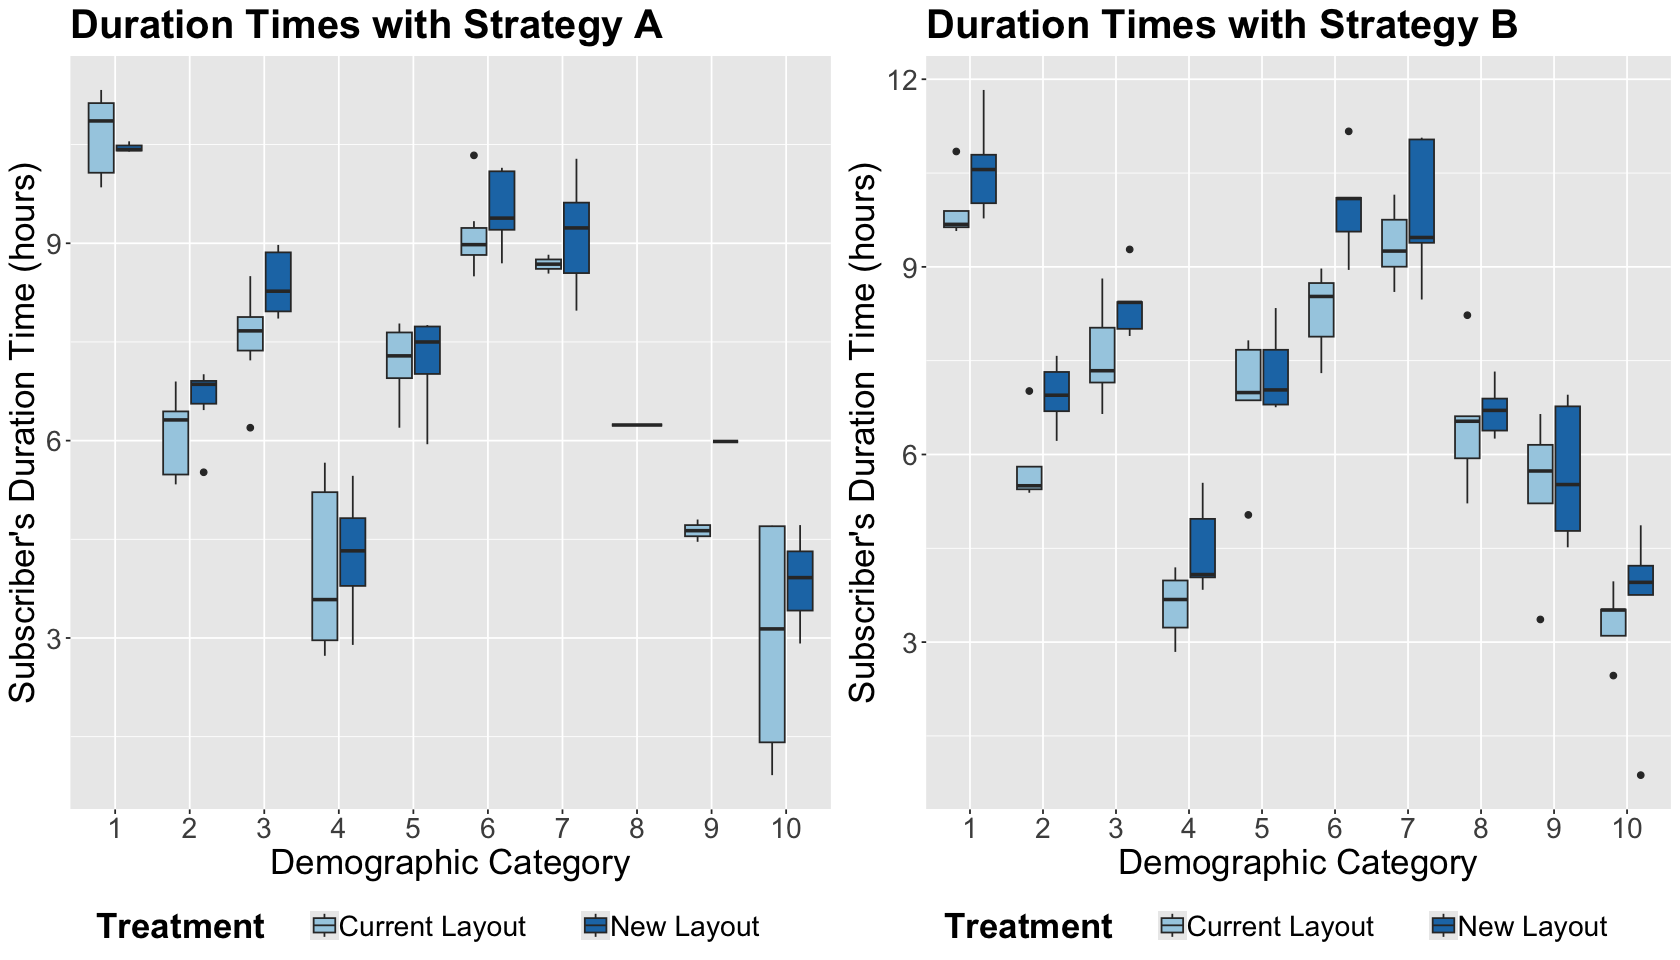

In [8]:
plot_grid(boxplots_data_exp_A, boxplots_data_exp_B)

```{exercise}
:label: lecture4-q1

What can we **graphically** conclude from the previous side-by-side boxplots?
```

By looking at the below stacked bar charts by **absolute frequencies**, we highlight the following:

- On the right-hand side, we have a **balanced representation** by demographic category given our randomization design by blocks **AND** treatments. Thus, we have the same number of observations within each demographic category.
- On the left-hand side, the blocks have different subscriber counts by treatment **since our randomization design was only done by treatments**.

In [9]:
exp_A_stacked_bars <- ggplot(sim_n_100$data_exp_A, aes(dmg, fill = x)) +
  geom_bar(width = 0.7, linewidth = 0.1) +
  xlab("Demographic Category") +
  ylab("Sampled Subscriber Counts") +
  ggtitle("Counts of Sampled Subscribers with Strategy A")  +
  theme(
    plot.title = element_text(size = 20, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 20),
    legend.position = "bottom",
    legend.title = element_text(size = 20, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm"))
  ) +
  scale_fill_brewer(palette = "Paired", name = "Treatment") + ylim(0, 20)

exp_B_stacked_bars <- ggplot(sim_n_100$data_exp_B, aes(dmg, fill = x)) +
  geom_bar(width = 0.7, linewidth = 0.1) +
  xlab("Demographic Category") +
  ylab("Sampled Subscriber Counts") +
  ggtitle("Counts of Sampled Subscribers with Strategy B")  +
  theme(
    plot.title = element_text(size = 20, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 20),
    legend.position = "bottom",
    legend.title = element_text(size = 20, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm"))
  ) +
  scale_fill_brewer(palette = "Paired", name = "Treatment") + ylim(0, 20)

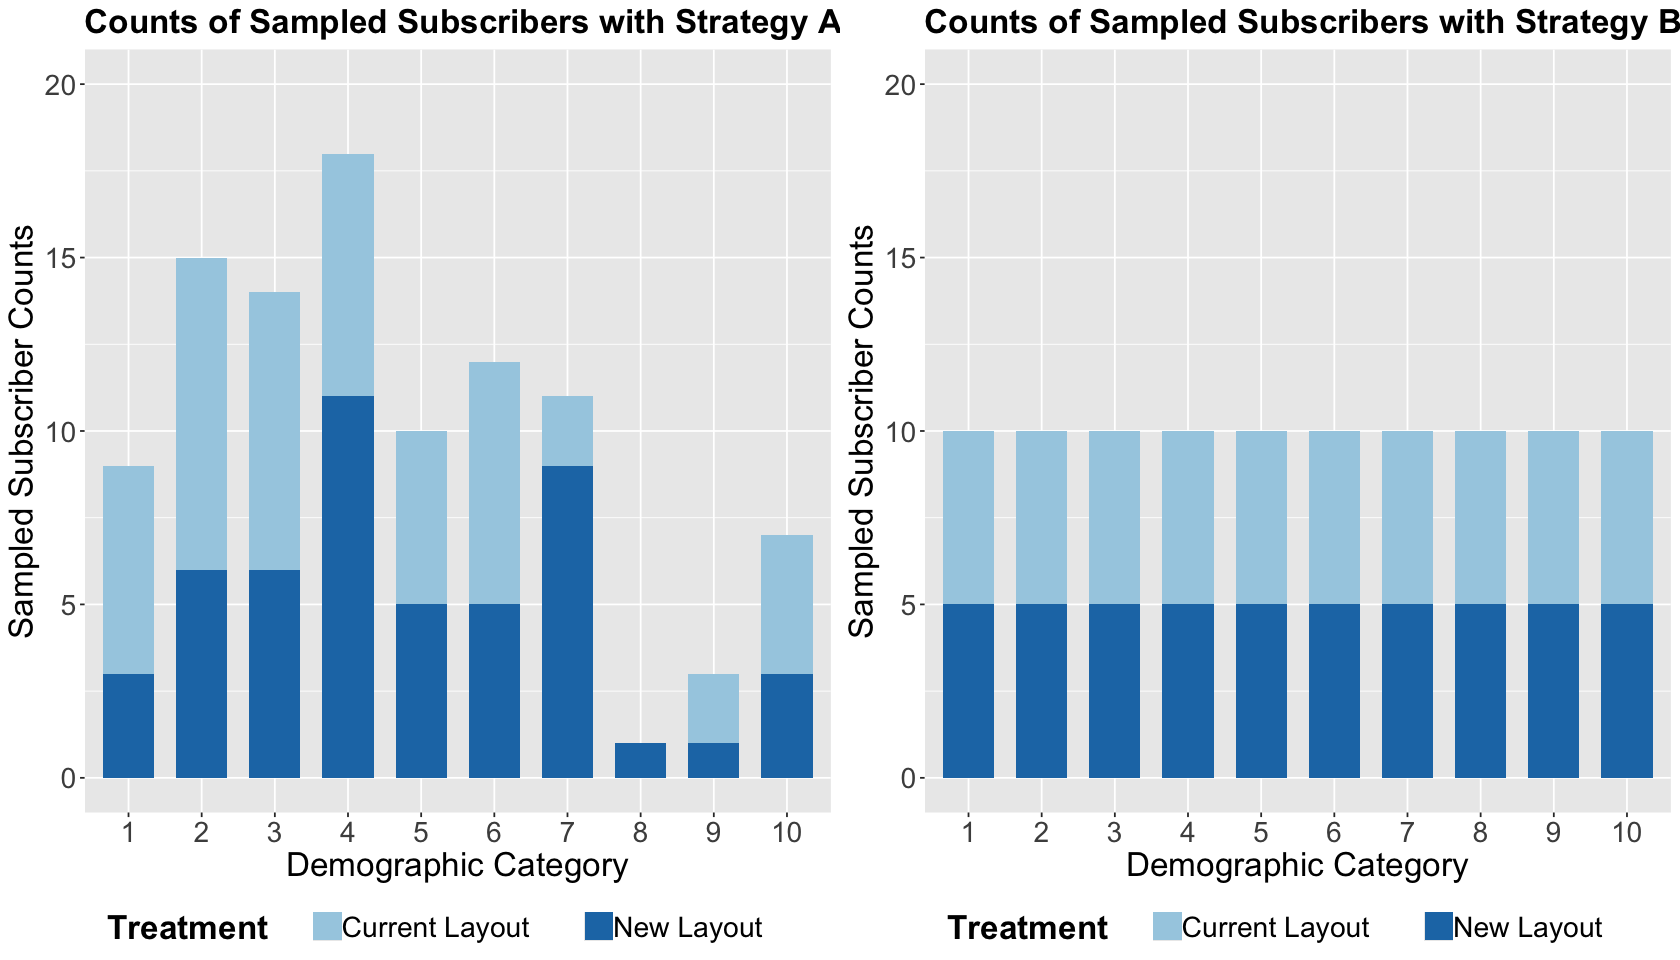

In [10]:
plot_grid(exp_A_stacked_bars, exp_B_stacked_bars)

```{admonition} What is the main takeaway from this EDA?
:class: hint
One of the main advantages of blocking design is that we can ensure a sufficient sample representation across the blocking categories, **especially with small sample sizes**.
```

###  1.5. Data Analysis

As done in {doc}`lecture3_randomization_and_blocking`, we will use the previous simulated datasets to fit the corresponding regression models under three modelling strategies.

#### Experiment A: Raw Model

This model will only regress the `y` on `x` (**current** versus **new** layout), Again, the only significant estimate is the one for the baseline (`(Intercept)`). **The model is not capturing the corresponding effect by demographic category.**

In [11]:
exp_A_raw_model_n100 <- lm(y ~ x, data = sim_n_100$data_exp_A) 
tidy(exp_A_raw_model_n100, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.91,0.34,20.59,0.00,6.25,7.58
xNew Layout,0.24,0.47,0.51,0.61,-0.70,1.19


#### Experiment A: Model with Post-Hoc Adjustment for Demographics

This model still uses the sample from **experiment A**, but we also include the sample demographic category `dmg` as a regressor. Note we have an accurate estimate of $\theta$ which is $0.42$ whose 95% confidence interval (CI) is $[0.09, 0.75]$. 

In [12]:
options(repr.matrix.max.rows = 15)

exp_A_adj_n100 <- lm(y ~ x + dmg, data = sim_n_100$data_exp_A)
tidy(exp_A_adj_n100, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),10.45,0.27,38.48,0.00,9.91,10.99
xNew Layout,0.42,0.17,2.52,0.01,0.09,0.75
dmg2,-4.34,0.34,-12.91,0.00,-5.01,-3.67
dmg3,-2.70,0.34,-7.93,0.00,-3.38,-2.03
dmg4,-6.52,0.33,-19.84,0.00,-7.18,-5.87
dmg5,-3.48,0.37,-9.47,0.00,-4.21,-2.75
dmg6,-1.34,0.35,-3.80,0.00,-2.04,-0.64
dmg7,-1.72,0.37,-4.69,0.00,-2.45,-0.99
dmg8,-4.63,0.85,-5.46,0.00,-6.32,-2.95


#### Experiment B: Model with Blocking

This model uses our data coming from the blocking design. It includes `x` and `dmg` as regressors. We have an accurate estimate of $\theta$ of $0.69$ whose 95% CI is $[0.35, 1.03]$.

In [13]:
exp_B_n100 <- lm(y ~ x + dmg, data = sim_n_100$data_exp_B) 
tidy(exp_B_n100, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),9.92,0.28,35.03,0.0,9.35,10.48
xNew Layout,0.69,0.17,4.04,0.0,0.35,1.03
dmg2,-3.87,0.38,-10.14,0.0,-4.63,-3.11
dmg3,-2.26,0.38,-5.91,0.0,-3.01,-1.50
dmg4,-6.22,0.38,-16.29,0.0,-6.98,-5.46
dmg5,-3.16,0.38,-8.28,0.0,-3.92,-2.40
dmg6,-1.13,0.38,-2.96,0.0,-1.89,-0.37
dmg7,-0.64,0.38,-1.68,0.1,-1.40,0.12
dmg8,-3.65,0.38,-9.56,0.0,-4.41,-2.89


```{exercise}
:label: lecture4-q2

Recall the **true population effect** is $\theta = 0.5$. Thus, let us focus the attention on the `tidy()` output for `xNew Layout` (i.e., estimate $\hat{\theta}$) for models `exp_A_adj_n100` and `exp_B_n100`. 

Regarding their corresponding 95% CIs for `xNew Layout`, what can we conclude on an inferential level? 

**Select the correct option:**

**A.** Only model `exp_A_adj_n100` provides a **precise** estimate for $\theta$.

**B.** Only model `exp_B_n100` provides a **precise** estimate for $\theta$.

**C.** Both models provide **precise** estimates for $\theta$.

**D.** Neither of the models provides **precise** estimates for $\theta$.
```

### 1.6. Increasing the Sample Size to $n = 1000$

Now, suppose the company allows you to increase the sample size to $n = 1000$. First, let us check whether this sample size increase will allow the **Raw Model** (no blocking) to provide **at least** an accurate estimate for $\theta = 0.5$.

In [14]:
set.seed(554)
sim_n_1000 <- AB_blocking(
  num_blocks = 10, n = 1000,
  sd_wthn_blocks = 0.8,
  theta = 0.5, alpha = block_effects
)

exp_A_raw_model_n1000 <- lm(y ~ x, data = sim_n_1000$data_exp_A) 
tidy(exp_A_raw_model_n1000, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),7.04,0.11,66.71,0,6.83,7.25
xNew Layout,0.59,0.15,3.94,0,0.30,0.88


At least, we are obtaining an accurate estimate for $\theta = 0.5$ this time (but not so precise!).

Let us do it with the **Model with Post-Hoc Adjustment for Demographics**. We still have an accurate estimate of $\theta$, which is $0.54$ but **more precise**. Its 95% CI is $[0.44, 0.64]$. 

In [15]:
exp_A_adj_n1000 <- lm(y ~ x + dmg, data = sim_n_1000$data_exp_A)
tidy(exp_A_adj_n1000, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),10.06,0.07,150.98,0,9.93,10.19
xNew Layout,0.54,0.05,10.67,0,0.44,0.64
dmg2,-4.32,0.09,-46.24,0,-4.50,-4.13
dmg3,-2.21,0.09,-24.21,0,-2.39,-2.03
dmg4,-6.43,0.09,-69.33,0,-6.61,-6.25
dmg5,-3.11,0.10,-31.13,0,-3.30,-2.91
dmg6,-0.90,0.10,-8.89,0,-1.10,-0.70
dmg7,-1.10,0.11,-9.73,0,-1.33,-0.88
dmg8,-3.65,0.12,-30.66,0,-3.88,-3.42


Finally, the **Model with Blocking** is estimated via the dataset with the blocking design. Again, the estimate of $\theta$ is accurate (i.e, $0.49$) with a more precise 95% CI of $[0.39, 0.58]$

In [16]:
exp_B_n1000 <- lm(y ~ x + dmg, data = sim_n_1000$data_exp_B) 
tidy(exp_B_n1000, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),10.03,0.08,122.62,0,9.87,10.19
xNew Layout,0.49,0.05,9.85,0,0.39,0.58
dmg2,-4.11,0.11,-37.27,0,-4.33,-3.89
dmg3,-2.12,0.11,-19.18,0,-2.33,-1.90
dmg4,-6.15,0.11,-55.73,0,-6.36,-5.93
dmg5,-3.21,0.11,-29.08,0,-3.42,-2.99
dmg6,-0.83,0.11,-7.56,0,-1.05,-0.62
dmg7,-0.90,0.11,-8.12,0,-1.11,-0.68
dmg8,-3.63,0.11,-32.92,0,-3.85,-3.41


```{admonition} What is the main takeaway from these simulation replicates when increasing $n$ from $100$ to $1000$?
:class: hint
Increasing the sample size to from $n = 100$ to $1000$ seems to make all modelling strategies accurate when estimating $\theta$ even with the **Raw Model A**! Recall that this model **does not capture the right systematic component of the population**, including the **stratum effect** (i.e., demographic categories). Moreover, the other two strategies (which take into account the demographic categories in their corresponding setups) are more **precise**.
```

```{exercise}
:label: lecture4-q3

Suppose you are in charge of running this A/B testing. Would you be tempted to suggest to your boss that sample sizes should be increased from $n = 100$ to $1000$?

**A.** Yes.

**B.** No.
```

## 2. Running a Comprehensive Simulation Study with Varying Sample Sizes

As discussed in {doc}`lecture3_randomization_and_blocking`, running a single simulation replicate is not enough to have a fully robust conclusion on the advantages of increasing the A/B testing sample size. 

Hence, using the same three modelling strategies from the previous section, let us run three **simulation studies** with varying sample sizes $n = 100, 500, 1000$. Each study will have 500 replicates.

```{important}
We are basically running Monte Carlo simulations!
```

The **average behaviour** will be tracked with the following metrics **per modelling strategy** with $\theta = 0.5$:

- **BIAS:** The average, over the 500 replicates, of $\hat{\theta} - \theta$. The larger the average, the less accuracy.
- **ROOT-MEAN-SQUARED ERROR (RMSE):** The square root of the average (over the 500 replicates) of $(\hat{\theta}-\theta)^{2}$.  It has the following characteristics:
    - Interpretable as the typical magnitude of estimation error.
    - Captures bias and variance involved in the procedure.
- **COVERAGE:** The proportion (among the 500 replicates) of the 95% CIs that contain the true $\theta$ value.
- **POWER:** It is applicable when $\theta \neq 0$. The proportion of the 500 95% CIs that exclude zero.

The code below executes the previous three strategies 500 times (`num_replicates`).

### 2.1. Main Statistical Inquiry

We will run different simulation studies while varying the **training sample sizes** to fit the corresponding ordinary least-squares (OLS) models by strategy. By running these simulation studies, we want to know **how the power improves as we increase the training sample sizes**.

### 2.2. Coding Up and Running the Simulation Studies

Our previous function `AB_blocking()` will be helpful to generate the datasets to be used in our three modelling strategies **for each simulation replicate**. Nonetheless, we need another function to execute each simulation study by sample size. This function will return a data frame with the previously defined metrics.

Thus, the following code sets up the function `sim_study()` with the same arguments as in `AB_blocking()` plus the number of replicates to execute in the study `num_replicates`. The function returns a data frame with the previous metrics **per sample size**.

In [17]:
sim_study <- function(num_blocks, n, alpha, sd_wthn_blocks, theta, num_replicates) {
  res <- list(NULL) # Setting up matrix with metrics
  res[[1]] <- res[[2]] <- res[[3]] <- matrix(NA, num_replicates, 3)

  for (lp in 1:num_replicates) {
    # Simulating datasets
    sim_datasets <- AB_blocking(
      num_blocks, n,
      sd_wthn_blocks,
      theta, alpha
    )

    # Do the three analyses
    ft_raw <- lm(y ~ x, data = sim_datasets$data_exp_A)
    ft_post_hoc_adj <- lm(y ~ x + dmg, data = sim_datasets$data_exp_A)
    ft_blocking <- lm(y ~ x + dmg, data = sim_datasets$data_exp_B)

    # and the takeaways
    res[[1]][lp, ] <- c(coef(ft_raw)["xNew Layout"], confint(ft_raw)["xNew Layout", ])
    res[[2]][lp, ] <- c(coef(ft_post_hoc_adj)["xNew Layout"], confint(ft_post_hoc_adj)["xNew Layout", ])
    res[[3]][lp, ] <- c(coef(ft_blocking)["xNew Layout"], confint(ft_blocking)["xNew Layout", ])
  }

  # Summaries
  BIAS <- sapply(
    res,
    function(mat) {
      mean(mat[, 1]) - theta
    }
  )
  vrnc <- sapply(res, function(mat) {
    var(mat[, 1])
  })
  CVRG <- sapply(res,
    function(mat, trg) {
      mean((mat[, 2] < trg) & (trg < mat[, 3]))
    },
    trg = theta
  )
  PWR <- sapply(res, function(mat) {
    mean(mat[, 2] > 0)
  })
  RMSE <- sqrt(BIAS^2 + vrnc)

  opt <- cbind(BIAS, RMSE, CVRG, PWR)
  rownames(opt) <- c("Raw Model A (nothing)", "Adjusted Model A (dmg as a covariate)", "Model B (blocking)")

  return(opt)
}

Now, we use our function `sim_study()` with 500 replicates per study while varying the sample sizes $n = 100, 500, 1000$. Note that the other function arguments are constant across the three studies.

In [18]:
set.seed(1234)

sim_study_n100 <- sim_study(
  num_blocks = 10, n = 100,
  alpha = block_effects, sd_wthn_blocks = 0.8,
  theta = 0.5, num_replicates = 500
)

sim_study_n500 <- sim_study(
  num_blocks = 10, n = 500,
  alpha = block_effects, sd_wthn_blocks = 0.8,
  theta = 0.5, num_replicates = 500
)

sim_study_n1000 <- sim_study(
  num_blocks = 10, n = 1000,
  alpha = block_effects, sd_wthn_blocks = 0.8,
  theta = 0.5, num_replicates = 500
)

### 2.3. Simulation Results

The summaries below corresponding the training sizes $n = 100, 500, 1000$.

In [19]:
round(sim_study_n100, 4)

,BIAS,RMSE,CVRG,PWR
Raw Model A (nothing),-0.0007,0.4741,0.944,0.202
Adjusted Model A (dmg as a covariate),0.0010,0.1736,0.944,0.820
Model B (blocking),0.0017,0.1517,0.960,0.892


In [20]:
round(sim_study_n500, 4)

,BIAS,RMSE,CVRG,PWR
Raw Model A (nothing),-0.0079,0.1984,0.952,0.672
Adjusted Model A (dmg as a covariate),0.0036,0.0763,0.936,1.000
Model B (blocking),0.0002,0.0757,0.934,1.000


In [21]:
round(sim_study_n1000, 4)

,BIAS,RMSE,CVRG,PWR
Raw Model A (nothing),-0.0075,0.1475,0.938,0.936
Adjusted Model A (dmg as a covariate),-0.0016,0.0483,0.964,1.000
Model B (blocking),-0.0024,0.0508,0.956,1.000


```{exercise}
:label: lecture4-q4

What is the main takeaway from these three simulation studies for $n = 100, 500, 1000$ in the context of this population of interest?
```

### 2.4. Examining Power with More Granular Sample Sizes

Our previous simulation studies already concluded that we could achieve an acceptable power level with no more than $n = 500$. 

```{admonition} Main Statistical Inquiry
:class: note
We might be interested in decreasing the sample size $n$ even more in an A/B testing without sacrificing power. **Recall the costs associated with a statistical experiment (i.e., A/B testing)!**
```

Let us run another eight simulation studies with $n = 20, 40, 60, 120, 240, 480, 600, 840, 1200$ and examine **power**. We will still use the function `AB_blocking()` with the same arguments except for `n` which will vary in each one of the three modelling strategies: **Raw Model A (nothing)**, **Adjusted Model A (`dmg` as a covariate)**, **Model B (blocking)**. 

There will be 500 replicates by study. The only overall metric to be recorded by study and modelling strategy will be **power (the proportion of the 500 95% CIs that exclude zero by modelling strategy)**.

```{important}
A **high power** indicates that our A/B testing is robust enough to detect and estimate an experimental treatment effect (i.e., $\theta$) different from zero.
```

In [22]:
n_replicates <- 500
sample_size <- c(20, 40, 60, 120, 240, 480, 600, 840, 1200)
n_lev <- length(sample_size)
n_strategy <- 3
pwr <- matrix(NA, n_lev, n_strategy) # Setting up summary matrix

set.seed(554) # Reproducibility
for (i in 1:length(sample_size)) {

  detect <- matrix(0.0, 1, n_strategy)
  
  for (lp in 1:n_replicates) {

    # Simulating datasets
    sim_datasets <- AB_blocking(
      num_blocks = 10, n = sample_size[i],
      sd_wthn_blocks = 0.8,
      theta = 0.5, alpha = block_effects
    )

    # Do the three analyses
    ft_raw <- lm(y ~ x, data = sim_datasets$data_exp_A)
    ft_post_hoc_adj <- lm(y ~ x + dmg, data = sim_datasets$data_exp_A)
    ft_blocking <- lm(y ~ x + dmg, data = sim_datasets$data_exp_B)

    # and the intermediate power calculations
    detect[1] <- detect[1] + (confint(ft_raw)["xNew Layout", 1] > 0)
    detect[2] <- detect[2] + (confint(ft_post_hoc_adj)["xNew Layout", 1] > 0)
    detect[3] <- detect[3] + (confint(ft_blocking)["xNew Layout", 1] > 0)
  }
  
  pwr[i, ] <- detect / n_replicates # Recording power computation by sample size
}

colnames(pwr) <- c("Raw Model A (nothing)", "Adjusted Model A (dmg as a covariate)", "Model B (blocking)")
rownames(pwr) <- paste0("n = ", sample_size)

From the below table, we can see that **Model B (blocking)** stands out in power for small sample sizes.

In [23]:
options(repr.matrix.max.rows = 20)

pwr

,Raw Model A (nothing),Adjusted Model A (dmg as a covariate),Model B (blocking)
n = 20,0.062,0.176,0.246
n = 40,0.106,0.384,0.478
n = 60,0.112,0.604,0.690
n = 120,0.208,0.876,0.912
n = 240,0.364,0.998,0.998
n = 480,0.668,1.000,1.000
n = 600,0.786,1.000,1.000
n = 840,0.904,1.000,1.000
n = 1200,0.952,1.000,1.000


Moreover, we can plot the previous table to get a clearer message.

In [24]:
pwr <- as_tibble(pwr) %>% 
  add_column(sample_size = c(20, 40, 60, 120, 240, 480, 600, 840, 1200))
pwr <- melt(pwr, id = c("sample_size"))

In [25]:
sim_power_plot <- ggplot(pwr, aes(x = sample_size, y = value, colour = variable)) +
  geom_point(size = 4) +
  geom_line(linewidth = 1) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 21),
    legend.position = "bottom",
    legend.title = element_text(size = 21, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.key.size = unit(2, "cm")
  ) +
  labs(x = "Overall Sample Size n", y = "Power") +
  coord_cartesian(xlim = c(20, 1200), ylim = c(0, 1)) +
  scale_y_continuous(breaks = seq(0, 1, 0.1)) +
  scale_x_continuous(breaks = sample_size) +
  ggtitle("A/B Testing Power (Blocking versus Non-Blocking)") +
  scale_colour_brewer(palette = "Dark2", name = "Model")

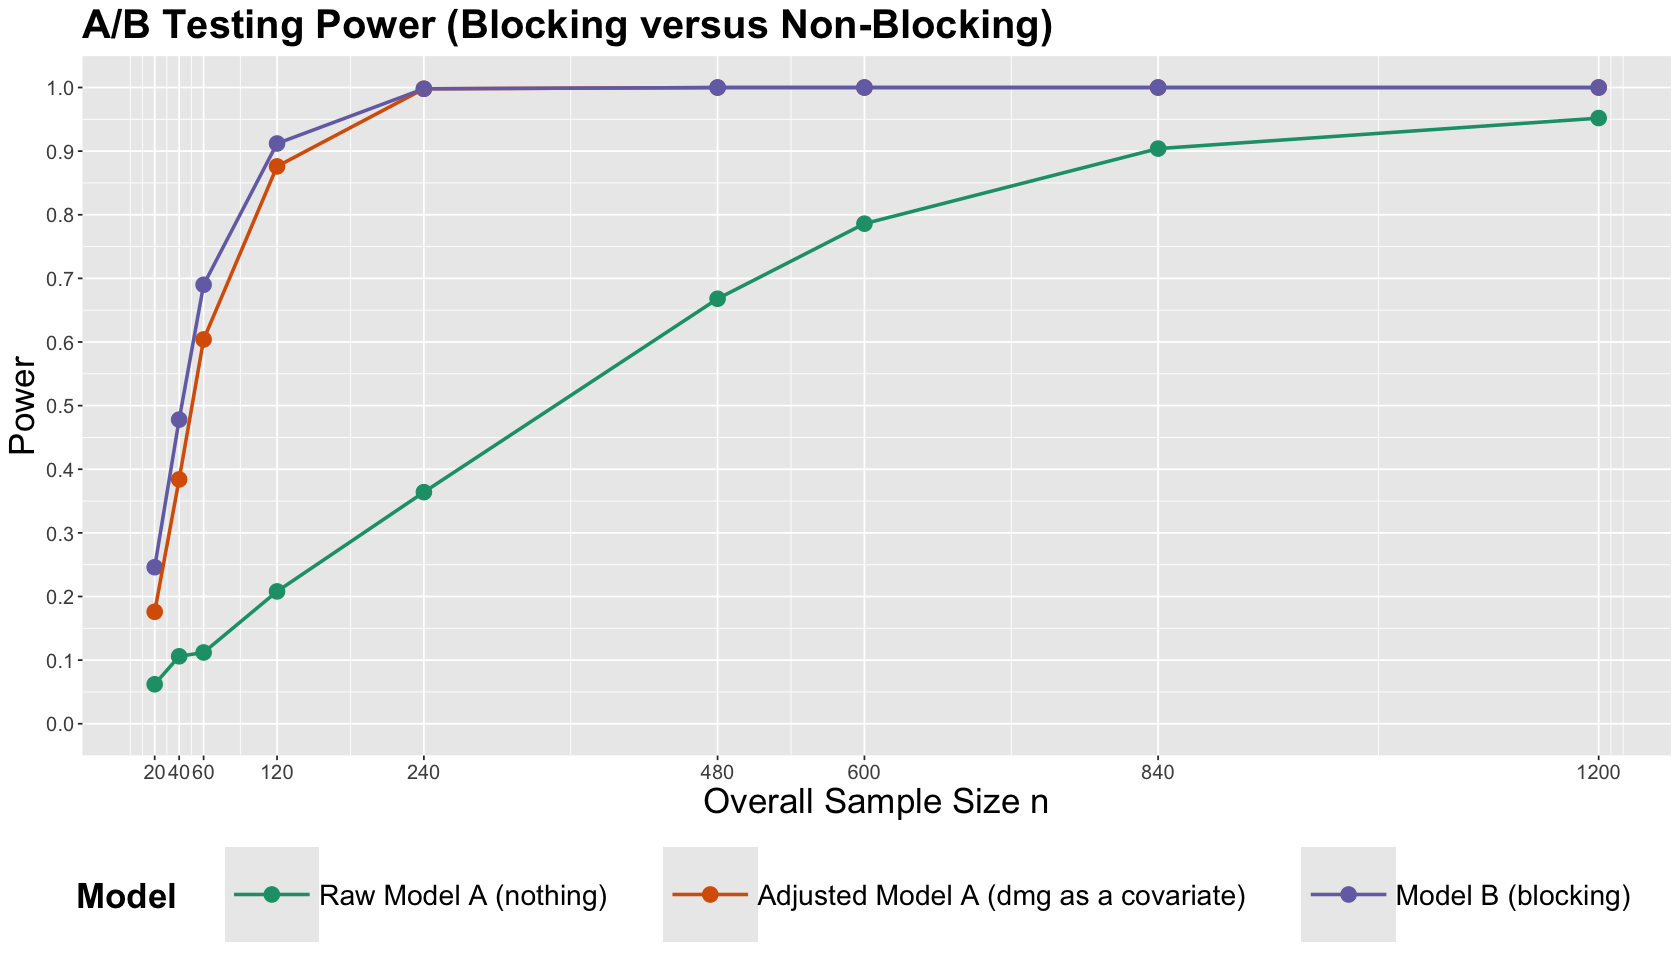

In [26]:
sim_power_plot

```{exercise}
:label: lecture4-q5

What is the main takeaway from these simulation studies in the context of this population of interest?
```

## 3. Power in Sample Size Computation in `R`

In this section of the lecture, **we will put aside simulations** and start exploring `R` ready-to-be-used formulas to compute sample sizes in A/B testing involving a continuous response $Y$ with a two-level factor $X$.

Recall that sample size computations involve playing around with three concepts: 
- **effect size** (how much we want the experimental treatment to differ from the control treatment in terms of the mean response), 
- **significance level $\alpha$**, and 
- the **power of the test** $1 - \beta$.

### 3.1. Power and Alpha Trade-Off

Recall that we set the significance level $\alpha$ to limit the **probability of a type I error** (falsely rejecting the null hypothesis when in fact is true).

```{caution}
Imagine you want to be **extremely strict** with guarding against ever making a Type I error by setting $\alpha = 0$ (never reject the null). However, this would be self-defeating **if possible** (we already discussed this scenario will never happen), and we would never detect actual departures from the null hypothesis $H_0$ (e.g., we will always fail to reject $H_0$ in this example even though $\theta \neq 0$!).
```

Recall there is a trade-off between $\alpha$ and the power of the test $1 - \beta$. Now, let us recall the probability $\beta$ is the type II error:

$$\text{Power} = 1 - \beta = 1 - P\{\textrm{do not reject null} \mid \ \textrm{alternative is true}\}.$$

### 3.2. A Practical Example

We want to do an A/B testing to see if a tweak (**version B**) of our existing site (**version A**) promotes site visitors to stay longer.

```{attention}
The boss will not sign off on this without some certainty around how many visitors will be randomized to either version A or B.
```

**Suppose we know that CURRENTLY, around 95% of the visitors stay between 30 seconds and 2 minutes.** Moreover, we would permanently switch to the tweaked site if we were convinced it improved visit length by 3% (or more!).

```{admonition} Main Statistical Inquiry
:class: note

Given the problem's setup, how large should we set up our sample size so we can detect this difference (if there is any!)?
```

Before using any suitable `R` function to compute sample sizes, we need to make a distributional assumption on the current visitor's time. Suppose that for **version A**, the duration time for the $i$th visitor is 

$$Y_i \sim \mathcal{N}(\mu_A, \sigma^2).$$

**How do we get $\mu_A$**? Recall we know the following:

> *Suppose we know that CURRENTLY, around 95% of the visitors stay between 30 seconds and 2 minutes.*

Assuming this distribution is symmetric (as in the Normal case!), then:

$$\mu_A = 0.5 + \frac{2 - 0.5}{2} = 1.25.$$

We also need to compute $\sigma^2$ if we want to use an `R` ready-to-be-used formula. Given that we assume normality on $Y_i$, we can use the **standardization formula in a Normal random variable**:

$$
P(0.5 \leq Y_i \leq 2) = 0.95
$$

$$
P \Bigg( \frac{0.5 - \mu_A}{\sigma} \leq \frac{Y_i - \mu_A}{\sigma} \leq \frac{2 - \mu_A}{\sigma} \Bigg) = 0.95.
$$

Note that 

$$Z_i = \frac{Y_i - \mu_A}{\sigma} \sim \mathcal{N}(0, 1).$$

We already know that the quantiles that ensure a **symmetric 95% coverage in a Standard Normal random variable** are 

$$
P(-1.96 \leq Z_i \leq 1.96) = 0.95.
$$


Therefore, we can obtain $\sigma$ as follows:

$$1.96 = \frac{2 - \mu_A}{\sigma}$$

$$1.96 = \frac{2 - 1.25}{\sigma}$$

$$\sigma = \frac{2 - 1.25}{1.96} = 0.383$$

or equivalently with $-1.96$ and $0.5$

$$\sigma = \frac{0.5 - 1.25}{-1.96} = 0.383.$$

**How to we get the desired difference $\delta$ in visit length between the two treatments**? Again, let us revisit the inquiry:

> *Moreover, we would permanently switch to the tweaked site if we were convinced it improved visit length by 3% (or more!).*

$$\delta = (\mu_A \times 1.03) - \mu_A = (1.25 \times 1.03) - 1.25 = 0.0375.$$

```{attention}
The term $\delta$ in this Power Analysis context **IS NOT** related to the term $\delta$ of the False Discovery Rate (FDR) from {doc}`lecture1_multiple_comparisons`.
```

```{important}
We also need a significance level $\alpha$, which we will set up with the standard value $\alpha = 0.05$. Now, what **power** do we need? Recall that this is the probability of rejecting the null when the difference is at least $\delta = 0.0375$. **A fairly common power choice is**

$$1 - \beta = 0.8.$$
```

Before using the `R` formula, let us review our sample size computation setup:

- We have set a **significance level** of $\alpha = 0.05$.
- We have estimated the **standard deviation** as $\sigma = 0.383$.
- We want detect an effect size of $\delta \geq 0.0375$ at least 80\% of the time (**power**).

The library `pwr` has the function `pwr.t.test()`. It needs the following arguments:

- `d`: Desired effect size (**$\delta$ divided by $\sigma$**).
- `sig.level`: Chosen $\alpha$.
- `power`: Chosen power $1 - \beta$.
- `type`: Type of test (in the A/B testing context we have a `two.sample` test).
- `alternative`: Our hypothesis test is one-sided, thus `greater`.

In [27]:
pwr.t.test(
  d = 0.0375 / 0.383,
  sig.level = 0.05,
  power = 0.8,
  type = "two.sample",
  alternative = "greater"
)


     Two-sample t test power calculation 

              n = 1290.509
              d = 0.09791123
      sig.level = 0.05
          power = 0.8
    alternative = greater

NOTE: n is number in *each* group


That is a large sample size **by treatment**! Hence, you will tell your boss the following:

> *If we run our experiment with $1291 \times 2 = 2582$ participants in total, then we have a 80% chance (or more) of being convinced of a difference between the two treatment groups, **provided that the population difference truly is $0.0375$** (**or greater**).*

**It is likely your boss will be surprised with that sample size.** Thus, they might be asking for another experimental setup options. And of course, you can provide options:

- $\alpha:$ **more strict** ($0.01$), **conventional value** ($0.05$), and **liberal** ($0.1$). The larger the $\alpha$, the more prone we will be to commit type I error.
- $1 - \beta$ (**power**): $0.5$ to $0.9$ by $0.05$. The larger the **power**, the less prone we will be to commit type II error.
- $\delta$: Possibly an increase $\delta = 0.0375$ is too small. We could also try $\delta = 0.05, 0.1$.

In [28]:
# Let us obtain all the possible setting combinations
alpha <- c(0.01, 0.05, 0.1)
power <- seq(from = 0.5, to = 0.9, by = 0.05)
delta <- c(0.0375, 0.05, 0.1)
experimental_grid <- expand.grid(alpha, power, delta)
colnames(experimental_grid) <- c("alpha", "power", "delta")
# Adding a column for the overall sample size n
experimental_grid$overall_n <- NA
experimental_grid

alpha,power,delta,overall_n
<dbl>,<dbl>,<dbl>,<lgl>
0.01,0.50,0.0375,NA
0.05,0.50,0.0375,NA
0.10,0.50,0.0375,NA
0.01,0.55,0.0375,NA
0.05,0.55,0.0375,NA
0.10,0.55,0.0375,NA
0.01,0.60,0.0375,NA
0.05,0.60,0.0375,NA
0.10,0.60,0.0375,NA


In [29]:
# Trying all settings from our previous grid

for (i in 1:nrow(experimental_grid)) {
  # Using sample size function
  sample_size <- tidy(pwr.t.test(
    d = experimental_grid[i, "delta"] / 0.383,
    sig.level = experimental_grid[i, "alpha"],
    power = experimental_grid[i, "power"],
    type = "two.sample",
    alternative = "greater"
  ))

  # Recording overal sample size
  experimental_grid[i, "overall_n"] <- 2 * ceiling(sample_size$n)
}

Note the whole table of 81 sample sizes might be hard to work with.

In [30]:
experimental_grid

alpha,power,delta,overall_n
<dbl>,<dbl>,<dbl>,<dbl>
0.01,0.50,0.0375,2262
0.05,0.50,0.0375,1132
0.10,0.50,0.0375,688
0.01,0.55,0.0375,2512
0.05,0.55,0.0375,1310
0.10,0.55,0.0375,828
0.01,0.60,0.0375,2780
0.05,0.60,0.0375,1506
0.10,0.60,0.0375,984


Therefore, let us make a clever plotting arrangement: **the so-called Power Analysis plots**.

In [31]:
sample_size_power_plot <- ggplot(experimental_grid, aes(x = power, y = overall_n, colour = as.factor(delta))) +
  geom_point(size = 4) +
  geom_line(linewidth = 1) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 13.5),
    axis.title = element_text(size = 21),
    strip.text = element_text(size = 21),
    legend.position = "bottom",
    legend.title = element_text(size = 21, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.key.size = unit(2, "cm")
  ) +
  labs(x = "Power", y = "Overall Sample Size n") +
  coord_cartesian(xlim = c(0.5, 0.9), ylim = c(0, 5500)) +
  scale_y_continuous(breaks = seq(0, 5500, 500)) +
  scale_x_continuous(breaks = power) +
  labs(colour = "Minute Response Increase\nwith Experimental Treatment B\n(% increase in brackets)") +
  ggtitle(expression("A/B Testing Power Analysis with"~alpha~"= 0.01, 0.05, 0.1")) +
  facet_wrap(~ as.factor(alpha)) +
  scale_colour_brewer(palette = "Dark2", labels = c("+0.0375 min (+3%)", "+0.05 min (+4%)", "+0.1 min (+8%)"))

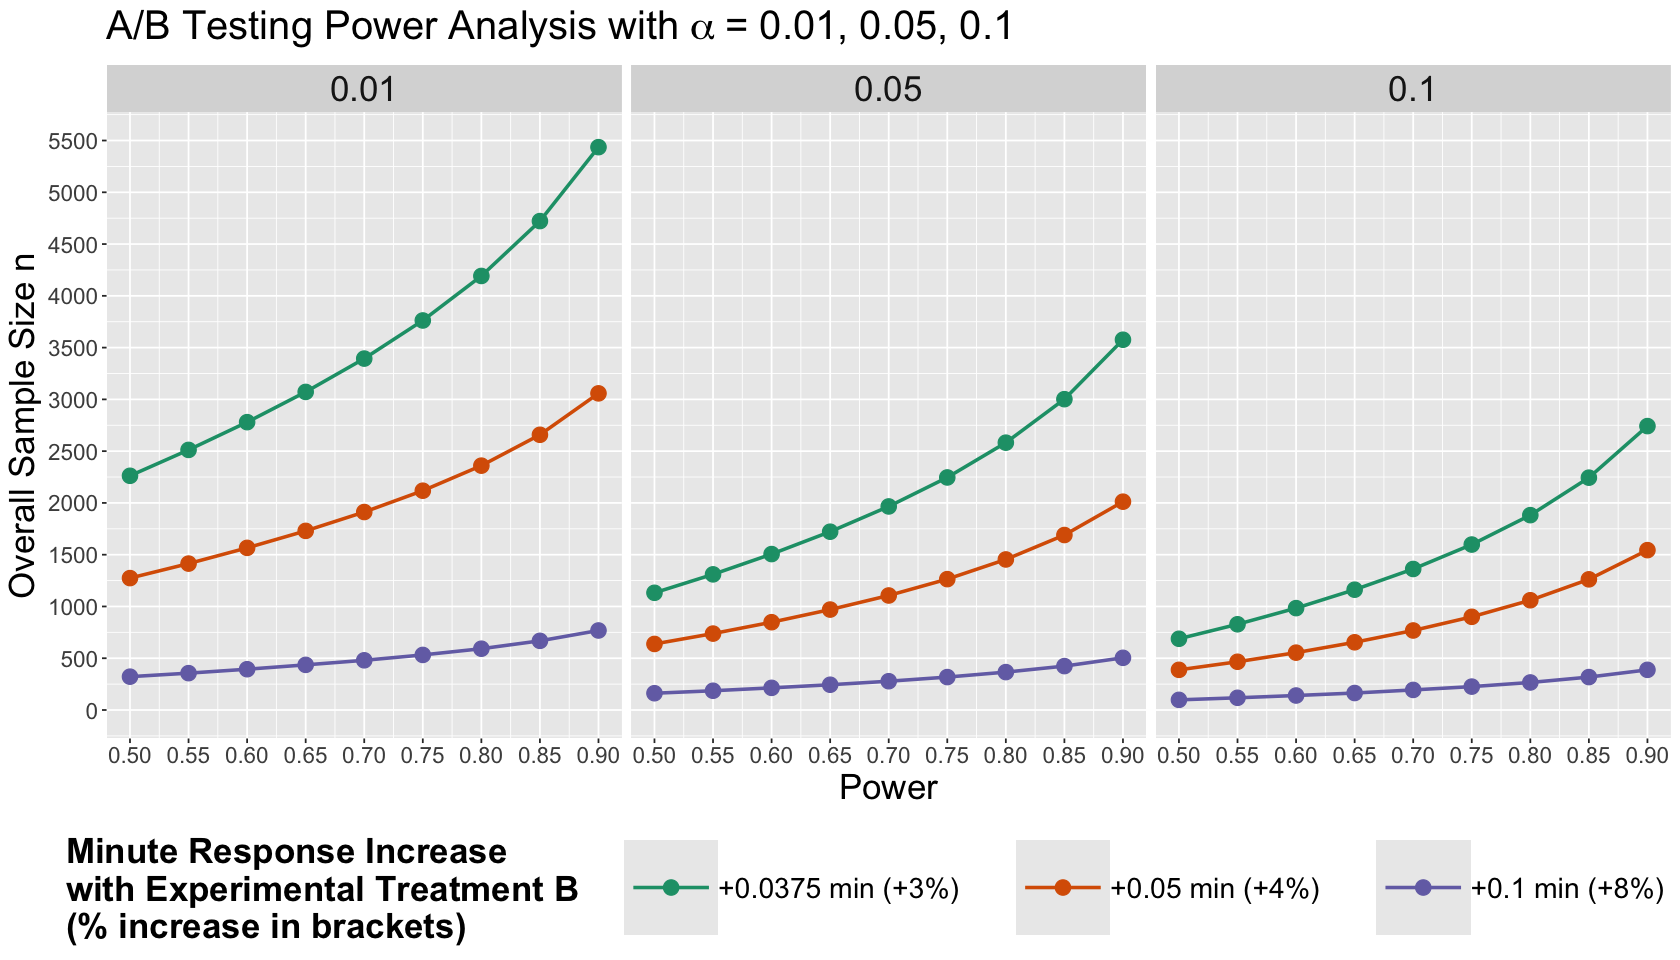

In [32]:
sample_size_power_plot

```{admonition} What are the main takeaways from this Power Analysis?
:class: hint
- **If we are incredibly optimistic about the potential success of our experimental treatment (i.e., large $\delta = 0.1$)**, then the required overall sample size $n$ will be small.
- A more strict $\alpha$ dramatically increases the required overall $n$.
- The more power, the more sample size we need!
```

## 4. Block Homogeneity and Power

**This is our final simulation study using today's initial case.** We will dig more into the following ideas we mentioned in {doc}`lecture3_randomization_and_blocking`:

> *An important matter to consider regarding blocking is that this strategy will work as long as the blocks are really homogeneous. This implicates stratifying the experimental units into blocks so that:*
>
> - *As much variation in $Y$ as possible is **across** the blocks.*
> - *As little variation in $Y$ as possible is **within** the blocks.*

Hence, you might wonder: **what do these statements imply in our experimental design an analysis IN TERMS OF POWER?**

To illustrate the previous ideas, let us tweak our modelling setup using our function `sim_study()` to get the corresponding summary metrics.

### 4.1. Scenario 1: Well-Defined Blocks with Low Internal Variability

Suppose that the strata in your population are really **well-defined** so the corresponding **between-block standard deviation** is high enough (e.g., `3`) in terms of our response of interest (subscriber's duration time on the website). On the other hand, the experimental units within each block are **really similar** (i.e., homogeneous!) in terms of the response of interest. Therefore, the **within-block standard deviation** is low enough (e.g., `0.5`)

Let us run the simulation study with a training size `n` of `100`, `10` blocks, a population $\theta = 0.5$, and 500 replicates.

In [33]:
set.seed(554) # Reproducibility
sd_btwn_blocks_1 <- 3 # Population between-block standard deviation
block_effects_1 <- rnorm(n = 10, sd = sd_btwn_blocks_1) # Simulating block effects
round(block_effects_1, 2)

[1]  2.44 -2.60 -0.10 -5.10 -1.31  1.38  1.21 -1.89 -3.02 -5.89

In [34]:
sim_study_homogeneous_blocks <- sim_study(
  num_blocks = 10, n = 100,
  alpha = block_effects_1, sd_wthn_blocks = 0.5,
  theta = 0.5, num_replicates = 500
)

### 4.2. Scenario 2: Poor-Defined Blocks with High Internal Variability

Now, let us switch the variabilities. Suppose the strata are **not well-defined**. Thus, the **between-block standard deviation** is low (e.g., `0.5`) in our response of interest. Furthermore, there is a lot of variability within the experimental units in the block (i.e., the block leans more to being heterogeneous). This matter will be translated into a high **within-block standard deviation** (e.g. `3`).

In [35]:
set.seed(554) # Reproducibility
sd_btwn_blocks_2 <- 0.5 # Population between-block standard deviation
block_effects_2 <- rnorm(n = 10, sd = sd_btwn_blocks_2) # Simulating block effects
round(block_effects_2, 2)

[1]  0.41 -0.43 -0.02 -0.85 -0.22  0.23  0.20 -0.31 -0.50 -0.98

In [36]:
sim_study_non_homogeneous_blocks <- sim_study(
  num_blocks = 10, n = 100,
  alpha = block_effects_2, sd_wthn_blocks = 3,
  theta = 0.5, num_replicates = 500
)

### 4.3. Comparing Both Scenarios

Now, let us check the numerical summaries:

In [37]:
round(sim_study_homogeneous_blocks, 3)

,BIAS,RMSE,CVRG,PWR
Raw Model A (nothing),0.016,0.541,0.932,0.166
Adjusted Model A (dmg as a covariate),-0.003,0.104,0.956,0.994
Model B (blocking),-0.004,0.098,0.948,0.998


In [38]:
round(sim_study_non_homogeneous_blocks, 3)

,BIAS,RMSE,CVRG,PWR
Raw Model A (nothing),0.002,0.590,0.960,0.118
Adjusted Model A (dmg as a covariate),-0.015,0.622,0.956,0.122
Model B (blocking),-0.026,0.589,0.948,0.098


```{admonition} What is the main takeaway from these simulation studies in the context of this population and power?
:class: hint
Blocking can be less beneficial if the within-block variation is (a lot!) higher than the between-block variation. Hence, we have to be extremely cautious when designing our A/B testing if we decide to go ahead with blocking. **The blocking setup needs to be carefully planned before running the experiment.**
```

##  5. Wrapping Up

- Blocking can give us a boost in power, especially for small sample sizes.
- So can include relevant covariates in our regression model, even with a randomized experiment!
- Power quantifies our ability to detect effects that really are there.
- For a desired power, we can calculate the required sample size.
- An important block characteristic is its clear definition in terms of the response of interest, i.e., we have to make sure our blocks are appropriately defined.